In [1]:
%pip install wandb

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install -Uq segmentation-models-pytorch

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install torchmetrics

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install pytorch_optimizer

Note: you may need to restart the kernel to use updated packages.


# Importing

In [5]:
import os
import pandas as pd 
import numpy as np
import cv2
import keras
from keras import layers
import tensorflow as tf
from keras.callbacks import EarlyStopping, LearningRateScheduler

import wandb
from wandb.keras import WandbCallback

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [6]:
# Warning
import warnings
warnings.filterwarnings("ignore")

tf.keras.backend.clear_session()
# Set the random seeds
os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
tf.random.set_seed(hash("by removing stochasticity") % 2**32 - 1)

In [7]:
BASE_PATH = "E:/nyu-depth-v2/nyu_data/"
df_train = pd.read_csv('E:/nyu-depth-v2/nyu_data/data/nyu2_train.csv', names=['image', 'label'])
df_test = pd.read_csv('E:/nyu-depth-v2/nyu_data/data/nyu2_test.csv', names=['image', 'label'])

# Preprocessing

In [8]:
class DataGenerator(tf.keras.utils.Sequence): # to generate data for batches of sample
    def __init__(self, data, batch_size=6, dim=(128, 128), n_channels=3, shuffle=True):
        """
        Initialization
        """
        self.data = data
        self.indices = self.data.index.tolist()
        self.dim = dim
        self.n_channels = n_channels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self): # generate the no of batchs
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index): # to generate a single batch based on provided index
        # Calculate start and end indices for the batch
        start_index = index * self.batch_size
        end_index = min((index + 1) * self.batch_size, len(self.indices))
        batch_indices = self.indices[start_index:end_index]
    
        # Generate data for the current batch`  `
        x, y = self.data_generation(batch_indices)
    
        return x, y

    def on_epoch_end(self): # CALLED AT the end of each epoch

        """
        Updates indexes after each epoch
        """
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def load(self, image_path, depth_path): # loads the input and target images
        """Load input and target image."""
       # image is converted to RGB and to float
        image_ = cv2.imread(BASE_PATH+image_path)
        image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)
        image_ = cv2.resize(image_, self.dim)
        image_ = tf.image.convert_image_dtype(image_, tf.float32)
        
        depth = cv2.imread(BASE_PATH+depth_path, cv2.IMREAD_UNCHANGED)
        depth = cv2.resize(depth, self.dim)
        depth = np.expand_dims(depth, axis=2)
        depth = tf.image.convert_image_dtype(depth, tf.float32)
        
        return image_, depth

    def data_generation(self, batch): # to load the data from the corresponding index

        x = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, 1))

        for i, batch_id in enumerate(batch):
            x[i,], y[i,] = self.load(image_path=self.data["image"][batch_id],
                                     depth_path=self.data["label"][batch_id])
            

        return x, y

In [9]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model

In [10]:
# Load pre-trained DenseNet169 without the classification head
encoder = DenseNet169(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

In [11]:
# Set encoder layers as non-trainable
for layer in encoder.layers:
    layer.trainable = False

In [12]:
# Define decoder architecture
decoder = tf.keras.Sequential([
    Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same'),
    Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same'),
    Conv2DTranspose(1, (2, 2), strides=2, activation='linear', padding='same')
])

In [13]:
# Combine encoder and decoder
input_tensor = encoder.input
intermediate_output = encoder.output
decoder_output = decoder(intermediate_output)

In [10]:
# Define the upgraded model
upgraded_model = Model(inputs=input_tensor, outputs=decoder_output)

In [11]:
# Compile the model
optimizer = tf.keras.optimizers.Adam()
upgraded_model.compile(optimizer=optimizer,
                       loss='mse',
                       metrics=["mse", "accuracy"])

In [12]:
# Setup callbacks
PATIENCE = 5  # Example patience value
early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=1,
    patience=PATIENCE,
)
callbacks = [early_stopping]

In [13]:
upgraded_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1/conv[0][0]']         

In [18]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose

# Initialize model
model = Sequential()

# Encoder
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))

# Decoder
model.add(Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same'))
model.add(Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu', padding='same'))
model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))  # Adjusted output layer

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Print model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 64, 64, 64)       36928     
 ranspose)                                                       
                                                      

In [7]:
BATCH_SIZE = 32
LR_INIT = 0.01
EPOCHS = 10
PATIENCE = 5
X, y = next(iter(DataGenerator(data=df_train[:1], batch_size=1)))
print(f"features shape example: {X.shape}")
print(f"target shape example: {y.shape}")
train_data = DataGenerator(data=df_train[:], batch_size=BATCH_SIZE)
valid_data = DataGenerator(data=df_test[:], batch_size=BATCH_SIZE)

features shape example: (1, 128, 128, 3)
target shape example: (1, 128, 128, 1)


In [15]:
# Train the upgraded model
history = upgraded_model.fit(train_data,
                              epochs=EPOCHS,
                              callbacks=callbacks,
                              validation_data=valid_data)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'gradient_tape/mean_squared_error/BroadcastGradientArgs' defined at (most recent call last):
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 595, in run_forever
      self._run_once()
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1881, in _run_once
      handle._run()
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Aparna\AppData\Local\Temp\ipykernel_46048\3719102653.py", line 2, in <module>
      history = upgraded_model.fit(train_data,
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\wandb\integration\keras\keras.py", line 176, in new_v2
      return old_v2(*args, **kwargs)
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\wandb\integration\keras\keras.py", line 176, in new_v2
      return old_v2(*args, **kwargs)
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\wandb\integration\keras\keras.py", line 176, in new_v2
      return old_v2(*args, **kwargs)
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_experimental\optimizer.py", line 526, in minimize
      grads_and_vars = self.compute_gradients(loss, var_list, tape)
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_experimental\optimizer.py", line 259, in compute_gradients
      grads = tape.gradient(loss, var_list)
Node: 'gradient_tape/mean_squared_error/BroadcastGradientArgs'
Incompatible shapes: [32,32,32,1] vs. [32,128,128,1]
	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_26013]

In [16]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

In [17]:

# Define your model
model = upgraded_model

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'accuracy'])

# Set up early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the model
history = model.fit(
    train_data,  # Your training dataset
    validation_data=valid_data,  # Your validation dataset
    epochs=EPOCHS,
    callbacks=[early_stopping]
)


Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'gradient_tape/mean_squared_error/BroadcastGradientArgs' defined at (most recent call last):
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 595, in run_forever
      self._run_once()
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1881, in _run_once
      handle._run()
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Aparna\AppData\Local\Temp\ipykernel_46048\2630498219.py", line 11, in <module>
      history = model.fit(
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\wandb\integration\keras\keras.py", line 176, in new_v2
      return old_v2(*args, **kwargs)
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\wandb\integration\keras\keras.py", line 176, in new_v2
      return old_v2(*args, **kwargs)
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\wandb\integration\keras\keras.py", line 176, in new_v2
      return old_v2(*args, **kwargs)
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_experimental\optimizer.py", line 526, in minimize
      grads_and_vars = self.compute_gradients(loss, var_list, tape)
    File "c:\Users\Aparna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_experimental\optimizer.py", line 259, in compute_gradients
      grads = tape.gradient(loss, var_list)
Node: 'gradient_tape/mean_squared_error/BroadcastGradientArgs'
Incompatible shapes: [32,32,32,1] vs. [32,128,128,1]
	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_41431]

In [8]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

In [9]:
BATCH_SIZE = 32
LR_INIT = 0.01
EPOCHS = 5
PATIENCE = 7

In [10]:
X, y = next(iter(DataGenerator(data=df_train[:1], batch_size=1)))
print(f"features shape example: {X.shape}")
print(f"target shape example: {y.shape}")

features shape example: (1, 128, 128, 3)
target shape example: (1, 128, 128, 1)


In [11]:
train_data = DataGenerator(data=df_train[:], batch_size=BATCH_SIZE)

In [12]:
valid_data = DataGenerator(data=df_test[:], batch_size=BATCH_SIZE)

In [13]:
model = keras.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((3, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.Conv2D(16, (3, 3), activation='relu'),
        layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same'),
        layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same'),
        layers.Conv2DTranspose(1, (2, 2), strides=2, activation='linear', padding='same'),
    ])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 32)        18464     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 16)        4

In [24]:
#optimizer = tf.keras.optimizers.SGD(LR_INIT)
optimizer= tf.keras.optimizers.Adam()


In [43]:
model.compile(optimizer=optimizer,
              loss='mse',
              metrics=["mse", "accuracy"],  # Add accuracy as a metric
             )


In [25]:
# Setup callbacks
early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=1,
    patience=PATIENCE,
)

exponential_decay_fn = exponential_decay(lr0=LR_INIT, s=30)
lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

callbacks = [
    early_stopping,
    #lr_callback
]


In [44]:
# Train the model
history = model.fit(train_data,
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    validation_data=valid_data
                   )

Epoch 1/5
1584/1584 [==============================] - 1612s 1s/step - loss: 0.0106 - mse: 0.0106 - accuracy: 2.0229e-07 - val_loss: 0.0534 - val_mse: 0.0534 - val_accuracy: 0.0268
Epoch 2/5
1584/1584 [==============================] - 1536s 969ms/step - loss: 0.0101 - mse: 0.0101 - accuracy: 2.0229e-07 - val_loss: 0.0516 - val_mse: 0.0516 - val_accuracy: 0.0268
Epoch 3/5
1584/1584 [==============================] - 1478s 933ms/step - loss: 0.0096 - mse: 0.0096 - accuracy: 2.0470e-07 - val_loss: 0.0576 - val_mse: 0.0576 - val_accuracy: 0.0268
Epoch 4/5
1584/1584 [==============================] - 1373s 867ms/step - loss: 0.0093 - mse: 0.0093 - accuracy: 2.0109e-07 - val_loss: 0.0632 - val_mse: 0.0632 - val_accuracy: 0.0268
Epoch 5/5
1584/1584 [==============================] - 1617s 1s/step - loss: 0.0090 - mse: 0.0090 - accuracy: 2.0350e-07 - val_loss: 0.0743 - val_mse: 0.0743 - val_accuracy: 0.0268


1/1 [==============================] - 0s 274ms/step


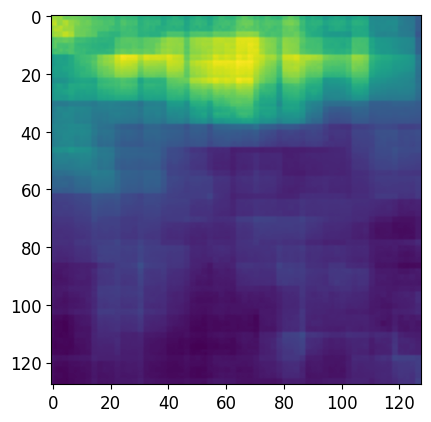

In [45]:
# make prediction to check what model has inferred
y_pred = model.predict(X)
plt.imshow(y_pred.reshape(128,128)*255)

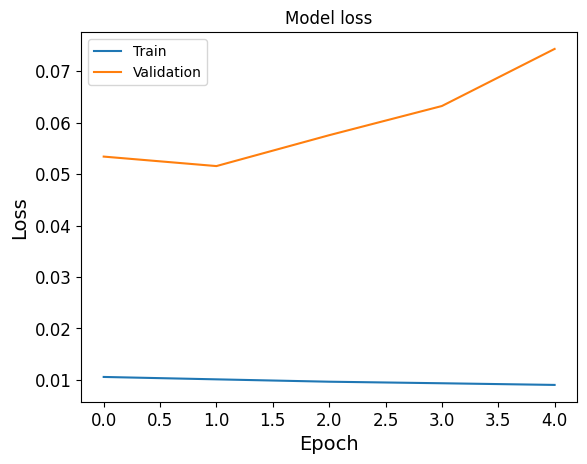

In [46]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()




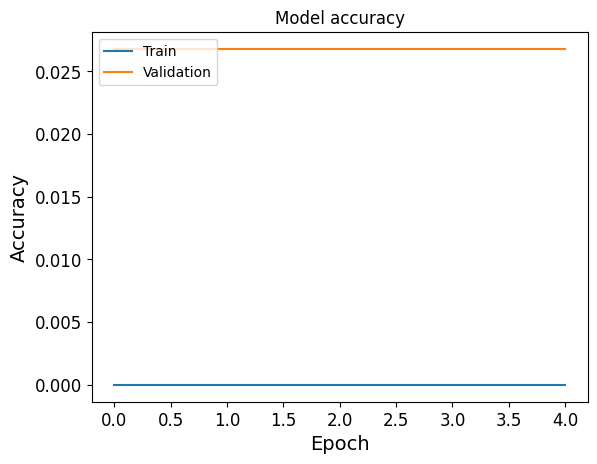

In [47]:
# Plot training & validation accuracy values
if 'accuracy' in history.history:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [9]:
%pip install tensorflow_addons


   ---------------------------------------- 0.0/719.8 kB ? eta -:--:--
   ---------------------------------------- 0.0/719.8 kB ? eta -:--:--
   ---------------------------------------- 0.0/719.8 kB ? eta -:--:--
    --------------------------------------- 10.2/719.8 kB ? eta -:--:--
    --------------------------------------- 10.2/719.8 kB ? eta -:--:--
    --------------------------------------- 10.2/719.8 kB ? eta -:--:--
   - ------------------------------------- 30.7/719.8 kB 186.2 kB/s eta 0:00:04
   - ------------------------------------- 30.7/719.8 kB 186.2 kB/s eta 0:00:04
   - ------------------------------------- 30.7/719.8 kB 186.2 kB/s eta 0:00:04
   - ------------------------------------- 30.7/719.8 kB 186.2 kB/s eta 0:00:04
   - ------------------------------------- 30.7/719.8 kB 186.2 kB/s eta 0:00:04
   -- ------------------------------------- 41.0/719.8 kB 85.3 kB/s eta 0:00:08
   -- ------------------------------------- 41.0/719.8 kB 85.3 kB/s eta 0:00:08
   -- ----

# ADD_ONS

In [33]:
BATCH_SIZE = 32
#LR_INIT = 0.01
EPOCHS = 10
PATIENCE = 7

In [14]:
X, y = next(iter(DataGenerator(data=df_train[:1], batch_size=1)))
print(f"features shape example: {X.shape}")
print(f"target shape example: {y.shape}")

features shape example: (1, 128, 128, 3)
target shape example: (1, 128, 128, 1)


In [17]:
train_data = DataGenerator(data=df_train[:], batch_size=BATCH_SIZE)

In [18]:
valid_data = DataGenerator(data=df_test[:], batch_size=BATCH_SIZE)

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np

In [20]:
# Define the model architecture
def build_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same'))
    model.add(Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu', padding='same'))
    model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))
    return model

In [21]:

model = build_model()


In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 64, 64, 64)       36928     
 ranspose)                                                       
                                                      

In [23]:
# Learning rate scheduler
def polynomial_decay(epoch):
    max_epochs = 10
    base_lr = 0.0001
    power = 1.0
    lr = base_lr * (1 - (epoch / float(max_epochs))) ** power
    return lr

In [24]:
def kmeans_loss(y_true, y_pred):
    # Reshape the images to flatten them
    y_true_flat = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
    y_pred_flat = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])

    # Perform K-means clustering
    kmeans = tf.compat.v1.losses.compute_weighted_loss(y_true_flat, y_pred_flat)

    return kmeans

In [25]:
def ssim_loss(y_true, y_pred):
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))
    return ssim_loss

In [26]:
def loss_function(y_true, y_pred):
    # Your previous loss components
    l_depth = tf.reduce_mean(tf.abs(y_pred - y_true))
    dy_true, dx_true = tf.image.image_gradients(y_true)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    l_edges = tf.reduce_mean(tf.abs(dy_pred - dy_true) + tf.abs(dx_pred - dx_true))
    l_ssim = tf.clip_by_value((1 - tf.image.ssim(y_true, y_pred, 1.0)) * 0.5, 0, 1)

    # K-means loss
    kmeans = kmeans_loss(y_true, y_pred)

    # SSIM loss
    ssim = ssim_loss(y_true, y_pred)

    # Weightage
    w1, w2, w3, w4, w5 = 1.0, 1.0, 0.1, 1.0, 1.0
    total_loss = (w1 * l_ssim) + (w2 * l_edges) + (w3 * l_depth) + (w4 * kmeans) + (w5 * ssim)
    return total_loss


In [27]:
# Initialize the model
model1 = Sequential()
model1.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)))
model1.add(MaxPooling2D((2, 2), padding='same'))
model1.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model1.add(MaxPooling2D((2, 2), padding='same'))
model1.add(Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same'))
model1.add(Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu', padding='same'))
model1.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

In [28]:
# Compile the model with custom loss function and optimizer
model1.compile(optimizer=tfa.optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-6, amsgrad=True),
              loss=loss_function,metrics=["mse", "accuracy"])

In [29]:
# Learning rate scheduler
def polynomial_decay(epoch):
    max_epochs = 10
    base_lr = 0.0001
    power = 1.0
    lr = base_lr * (1 - (epoch / float(max_epochs))) ** power
    return lr

In [30]:
# Define callbacks
callbacks = [LearningRateScheduler(polynomial_decay, verbose=1)]

In [43]:
# Train the model
history = model1.fit(
    train_data,  # Your training dataset
    validation_data=valid_data,  # Your validation dataset
    epochs=EPOCHS,
    callbacks=callbacks
)



Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/10
1584/1584 [==============================] - 2667s 2s/step - loss: 0.4270 - mse: 0.0281 - accuracy: 1.2041e-09 - val_loss: 1.0551 - val_mse: 0.0411 - val_accuracy: 0.0268 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9e-05.
Epoch 2/10
1518/1584 [===========================>..] - ETA: 7:44 - loss: 0.4032 - mse: 0.0263 - accuracy: 0.0000e+00

In [41]:
print(EPOCHS)

10
